# Generator

Predict water_level

In [30]:
from pandas import read_csv
from matplotlib import pyplot
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras import Model

from keras.models import Sequential
from keras.layers import Dense, Input, Attention
from keras.layers import LSTM
from keras.layers import Layer
from keras.layers import *
from keras.models import *
from keras import backend as K

from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor


In [31]:
#load data
# dataset = read_csv('data_myrtle.csv', header=0, usecols = [2], engine='python')
def load_data():
    dataset = read_csv('../solar_AL.txt', header=0, usecols = [5], engine='python')
    dataset[:] = numpy.nan_to_num(dataset)

    dataset.plot(subplots=True, figsize=(8,8))
    
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    return scaler, dataset


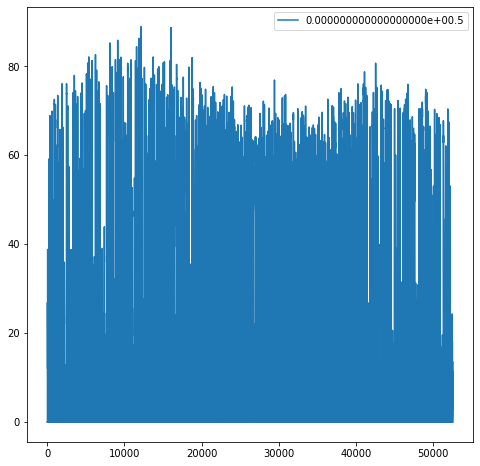

In [32]:
scaler, dataset = load_data()

In [33]:
# split into train and test sets
# use k-fold later to split
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

35214 17345


In [34]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [35]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(testY)
print(trainX)

[0.56186727 0.75309336 0.51574803 ... 0.         0.         0.        ]
[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.21766029]
 [0.27052868]
 [0.34251969]]


In [36]:
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], look_back, testX.shape[1]))
# at this point reshape just works for lookback = 1 need to find a way to denote for multivariate prediction
# we are doing a univariate one first

In [37]:
def make_model():
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(16, activation = 'tanh', kernel_initializer = 'he_normal'))
    model.add(Dense(8, activation = 'tanh', kernel_initializer = 'he_normal'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.compile(loss='mse', optimizer='adam') 
    model.summary()
    return model
print(testX)
print(testY)
model = make_model()
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

[[[0.47637795]]

 [[0.56186727]]

 [[0.75309336]]

 ...

 [[0.        ]]

 [[0.        ]]

 [[0.        ]]]
[0.56186727 0.75309336 0.51574803 ... 0.         0.         0.        ]
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 4)                 96        
                                                                 
 dense_12 (Dense)            (None, 16)                80        
                                                                 
 dense_13 (Dense)            (None, 8)                 136       
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/

In [38]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
traingen = trainPredict
testgen = testPredict

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
gen_testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
print(testY)

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], gen_testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# trainScore = math.sqrt(r2_score(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f R2' % (trainScore))
# testScore = math.sqrt(r2_score(testY[0], testPredict[:,0]))
# print('Test Score: %.2f R2' % (testScore))


[[49.95 66.95 45.85 ...  0.    0.    0.  ]]
Train Score: 4.47 RMSE
Test Score: 4.06 RMSE


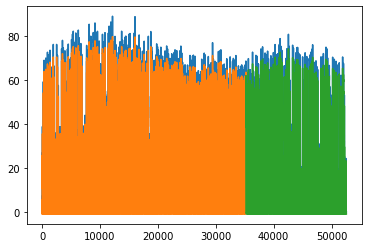

In [39]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = gen_testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Discriminator



[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[0.66644562]
 [0.79111406]
 [0.28580902]
 ...
 [0.56564987]
 [0.56564987]
 [0.56564987]]


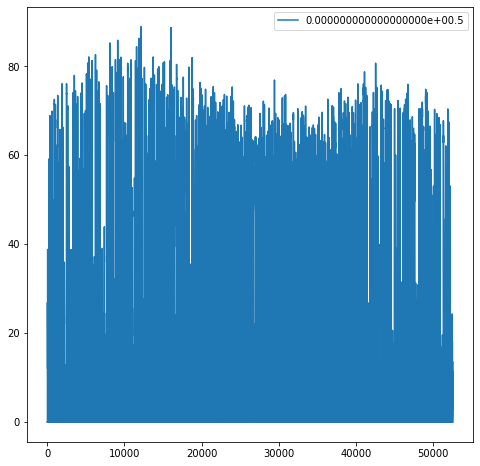

In [40]:
scaler, dataset = load_data()
# need to run first two cells to reset the dataset
dataset = scaler.inverse_transform(dataset)
print(dataset)
trainY = dataset[1 : train_size - 1] - dataset[: train_size - 2]
testY = dataset[train_size + 1 : -1] - dataset[train_size: -2]

trainY = scaler.fit_transform(trainY)
testY = scaler.fit_transform(testY)
print(testY)

In [41]:
disc_model = make_model()
disc_model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 4)                 96        
                                                                 
 dense_15 (Dense)            (None, 16)                80        
                                                                 
 dense_16 (Dense)            (None, 8)                 136       
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
35212/35212 - 35s - loss: 0.0021 - 35s/epoch - 992us/step
Epoch 2/20
35212/35212 - 34s - loss: 0.0019 - 34s/epoch - 979us/step
Epoch 3/20
35212/35212 - 34s - loss: 0.0019 - 34s/

In [42]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
disc_testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

print(testPredict)
print(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, disc_testPredict))
print('Test Score: %.2f RMSE' % (testScore))


[[ 0.43279153]
 [ 0.50869685]
 [ 0.69648194]
 ...
 [-0.00997877]
 [-0.00997877]
 [-0.00997877]]
[[  7.6]
 [ 17. ]
 [-21.1]
 ...
 [  0. ]
 [  0. ]
 [  0. ]]
Train Score: 31.71 RMSE
Test Score: 36.91 RMSE


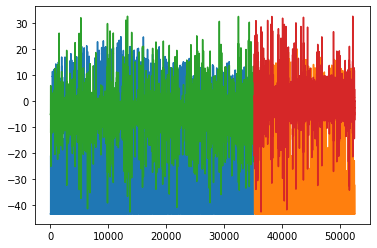

In [43]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

trainGenPlot = numpy.empty_like(dataset)
trainGenPlot[:, :] = numpy.nan
trainGenPlot[look_back:len(trainY)+look_back, :] = trainY

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = disc_testPredict

testGenPlot = numpy.empty_like(dataset)
testGenPlot[:, :] = numpy.nan
testGenPlot[len(traingen)+(look_back*2)+1:len(dataset)-1, :] = testY
# plot baseline and predictions
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.plot(trainGenPlot)
plt.plot(testGenPlot)
plt.show()

# Generator and Discriminator

[[ 38.354996]
 [ 52.154694]
 [ 83.60895 ]
 ...
 [-45.397923]
 [-45.397923]
 [-45.39793 ]]
[[49.95]
 [66.95]
 [45.85]
 ...
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]]
Train Score: 38.36 RMSE


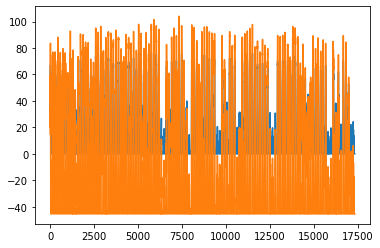

In [17]:
y_final = gen_testPredict + disc_testPredict
print(y_final)
print(dataset[train_size + 1: -1])

trainScore = math.sqrt(mean_squared_error(y_final, dataset[train_size + 1: -1]))
print('Train Score: %.2f RMSE' % (trainScore))
plt.plot(dataset[train_size:])
plt.plot(y_final)